Given a genomic region (union of continous DNA portions) segmented into short DNA words, we build a statistics taking into account the frequency of occurrence of each word and the frequency of co-occurrence of pairs of words in the same window (this can be the fragment or a larger bin in the genome). We can keep the information about the linear location of the fragments or not (the best strategy can be chosen afterwards depending on the result of clustering, for example). 

In [1]:
import sys
import csv
import numpy as np
import os.path
import cPickle as pickle
import matplotlib.pyplot as plt
import gensim, logging
from os import listdir
from os.path import isfile, join

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
###############################################################                                                                                                                                             
import sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

Given a bam file, we select the 50bp left/right extension of the reference locations (reference genome is GRCh37). We tokenize these fragments and build a document-term matrix from the segmented chr 1 to 22 (no X, Y and MT). This matrix is extremely sparse given tha large size of the vocabulary and the small number of terms per document.

In [ ]:
vectorizer = CountVectorizer(min_df=1) # set the min numb of times a word can occur
corpus = open('/home/garner1/Work/dataset/refgenomeLP/docs/1.doc')
dtm = vectorizer.fit_transform(corpus) # get document-term matrix                                                                                                                                           
vocab = vectorizer.get_feature_names() # a list  

Get the occurrence of each unique word in the list of documents, and observe how the majority of the words is rare and there are few words shared by the majority of the documents. 

In [ ]:
print (dtm.shape)
dtm_word = dtm.sum(axis=0)
print (dtm_word.shape)

%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

ax = sns.distplot(dtm_word[(dtm_word<10000) & (dtm_word>1)], bins=20, kde=False)
ax.set_yscale('log')
ax.set_ylabel('number of unique words occurring x times')
ax.set_xlabel('x = number of documents sharing a given unique word')

Decompose the document-term matrix using truncated SVD (note that singular values are sorted in ascending order). This identifies main "topics" (each one an ensemble of words of different weights, as expressed by vt rows), and the relevance of each topic for the list of documents is given by u columns:

In [ ]:
from scipy.sparse.linalg import svds, eigs

u, s, vt = svds(dtm.asfptype(), k=10)
import seaborn as sns
sns.set(color_codes=True)
sns.pointplot(range(len(s)),s)

In [ ]:
from bokeh.plotting import figure, output_file, show

# prepare some data
mode = 8
#x = range(len(u[:,vec]))
#y = u[:,vec]
x = range(len(vt[mode,:]))
y = vt[mode,:]

# output to static HTML file
output_file("lines.html")

# create a new plot with a title and axis labels
p = figure(title="eigenword", x_axis_label='document', y_axis_label='y')

# add a line renderer with legend and line thickness
p.circle(x, y, legend="Temp.", size=6)

# show the results
show(p)

A term-term co-occurence matrix is obtained as the product of dtm.T * dtm. This also is a sparse matrix and, after truncated SVD, we can identify main eigenwords:

In [ ]:
from scipy.sparse import coo_matrix
from numpy import *
"""
Compute the PPMI values for the raw co-occurrence matrix.
PPMI values will be written to mat and it will get overwritten.
"""    
mat = dtm.transpose().dot(dtm)      # build word-word matrix
rows,cols = mat.nonzero() # get the list of non-zero rows and cols index
data = np.divide(mat.data*1.0,dtm_word[0,rows]*1.0) # pointwise division of data matrix by row-sum
data = np.divide(data,dtm_word[0,cols]*1.0) # pointwise division by col-sum
data = data*dtm_word.sum() #rescaling by number of tokens
data = np.squeeze(np.asarray(data))

coomat = coo_matrix((data, (rows, cols)), shape=mat.shape) # sparse mat in coordinate format
coomat.data = ma.log(coomat.data)
coomat.data = ma.masked_less(coomat.data, 0)

In [ ]:
from scipy.sparse.linalg import svds

[u,s,vt] = svds(coomat, k=6, which='LM', return_singular_vectors=True)

Load the pickle files containing the vocabulary and the truncated singular value components U, S, VT at k=6

In [3]:
allfiles = [] # Creates an empty list
ind = 0
for root, dirs, files, in os.walk("/home/garner1/Work/dataset/refgenomeLP/pickle_vocabularies/"):
    for file in files:
        ind = ind+1
        if file.endswith(".p"):
            print (file)
            print (str(ind) + " of " + str(len(files)) )
            openfiles = open(os.path.join(root, file), 'rb')
            loadedfiles = pickle.load(openfiles)
            allfiles.append(loadedfiles)

XZ119.genome.doc.p
1 of 16
XZ121.genome.doc.p
2 of 16
XZ120.genome.doc.p
3 of 16
XZ82.genome.doc.p
4 of 16
XZ114.genome.doc.p
5 of 16
XZ88.genome.doc.p
6 of 16
XZ86.genome.doc.p
7 of 16
XZ122.genome.doc.p
8 of 16
XZ89.genome.doc.p
9 of 16
XZ85.genome.doc.p
10 of 16
XZ90.genome.doc.p
11 of 16
XZ83.genome.doc.p
12 of 16
XZ117.genome.doc.p
13 of 16
XZ118.genome.doc.p
14 of 16
XZ115.genome.doc.p
15 of 16
XZ91.genome.doc.p
16 of 16


Print the length of all vocabularies:

In [7]:
for ind in range(16):
    print(ind,len(allfiles[ind][0]))

(0, 5572869)
(1, 5497812)
(2, 5672489)
(3, 5680769)
(4, 4465900)
(5, 4245431)
(6, 4932394)
(7, 5835234)
(8, 5447224)
(9, 5173049)
(10, 5531376)
(11, 5202919)
(12, 5808104)
(13, 3773472)
(14, 4429137)
(15, 5725429)


Evaluate the intersection of different sets:

In [12]:
oldset = set(allfiles[0][0])
for ind in range(1,16):
    print (len(oldset))
    newset = set(allfiles[ind][0])
    common_voc = set.intersection(oldset,newset)
    oldset = common_voc

5572869
4796189
4391852
4137231
3446704
2817330
2603217
2554646
2486328
2402500
2363566
2287332
2277549
1965027
1876377


In [51]:
vectorizer = CountVectorizer(min_df=1, vocabulary=common_voc) # set the min numb of times a word can occur
corpus = open('/home/garner1/Work/dataset/refgenomeLP/XZ114/docs/1.doc')
dtm = vectorizer.fit_transform(corpus) # get document-term matrix                                                                                                                                           

Load the truncated SVD from each sample:

In [2]:
allfiles = [] # Creates an empty list
ind = 0
for root, dirs, files, in os.walk("/home/garner1/Work/dataset/refgenomeLP/SVD_from_DTM/"):
    for file in files:
        ind = ind+1
        if file.endswith(".p"):
            print (file)
            print (str(ind) + " of " + str(len(files)) )
            openfiles = open(os.path.join(root, file), 'rb')
            loadedfiles = pickle.load(openfiles)
            allfiles.append(loadedfiles)

XZ88.p
1 of 16
XZ86.p
2 of 16
XZ82.p
3 of 16
XZ121.p
4 of 16
XZ122.p
5 of 16
XZ91.p
6 of 16
XZ117.p
7 of 16
XZ90.p
8 of 16
XZ118.p
9 of 16
XZ83.p
10 of 16
XZ114.p
11 of 16
XZ85.p
12 of 16
XZ120.p
13 of 16
XZ89.p
14 of 16
XZ115.p
15 of 16
XZ119.p
16 of 16


Plot the singular values of different sampeles:

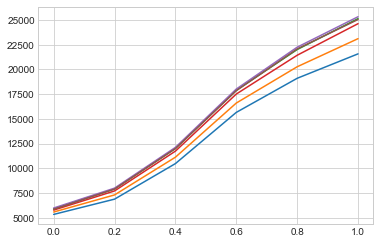

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 1, 6)
for ind in range(6):
    ax.plot(x, allfiles[ind][1])

Multiply U with S for each sample

In [49]:
X = np.zeros( (len(allfiles),allfiles[0][0].shape[0]*allfiles[0][0].shape[1]) )
for ind in range(6):
    a = np.asarray(allfiles[ind][0])
    b = np.diag( allfiles[ind][1] ) 
    X[ind,:] = np.dot(a, b).reshape((1,a.shape[0]*b.shape[1])) 

In [54]:
from scipy.spatial.distance import pdist, squareform

Y = pdist(X, 'euclidean')
D = squareform(Y)

In [57]:
print(D[0,:])

[    0.          5170.95692139  8011.13310296  6989.1698261
 41791.39449748  8243.23321471 35518.15719322 35518.15719322
 35518.15719322 35518.15719322 35518.15719322 35518.15719322
 35518.15719322 35518.15719322 35518.15719322 35518.15719322]


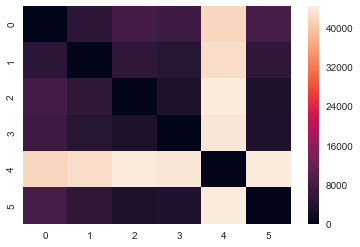

In [58]:
import seaborn as sns; sns.set()

ax = sns.heatmap( D[:6,:6] )

/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


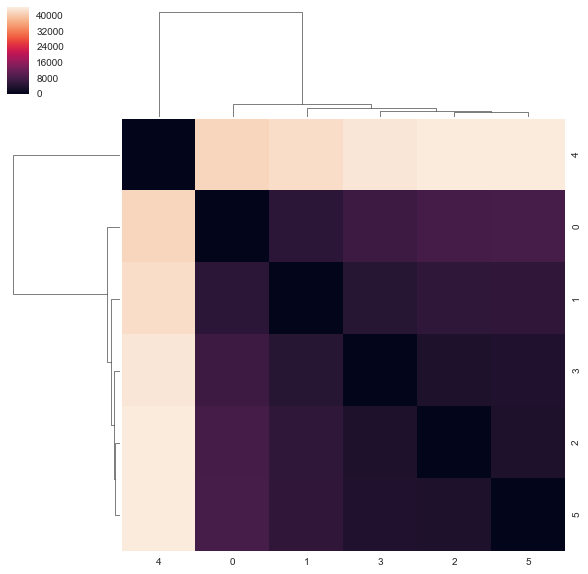

In [63]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import seaborn as sns; sns.set()

linkage = hc.linkage(D[:6,:6], method='average')
sns.clustermap(D[:6,:6], row_linkage=linkage, col_linkage=linkage)